In [1]:
import sys
path ='/home/ashesh.ashesh/code/Disentangle'
if path in sys.path:
    sys.path.remove(path)
sys.path

['/home/ashesh.ashesh/.local/share/uv/python/cpython-3.13.7-linux-x86_64-gnu/lib/python313.zip',
 '/home/ashesh.ashesh/.local/share/uv/python/cpython-3.13.7-linux-x86_64-gnu/lib/python3.13',
 '/home/ashesh.ashesh/.local/share/uv/python/cpython-3.13.7-linux-x86_64-gnu/lib/python3.13/lib-dynload',
 '',
 '/localscratch/code/Disentangle/.venv/lib/python3.13/site-packages',
 '/localscratch/code/FinetuneSplit/src',
 '__editable__.semanticunmix-0.1.0.finder.__path_hook__']

In [2]:
from IPython.display import display, HTML
import os
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import torch
import numpy as np
import seaborn as sns

from disentangle.data_loader.patch_index_manager import TilingMode
from disentangle.core.sampler_type import SamplerType
from disentangle.core.loss_type import LossType
from disentangle.data_loader.ht_iba1_ki67_rawdata_loader import SubDsetType
from disentangle.analysis.stitch_prediction import stitch_predictions
from disentangle.analysis.mmse_prediction import get_dset_predictions
from disentangle.core.psnr import PSNR
from disentangle.core.psnr import RangeInvariantPsnr

from finetunesplit.forward_operator_parameters import get_forward_operator_parameters
from finetunesplit.posterior_sampler import get_transform_obj, PosteriorSampler, get_input_transform_obj
from finetunesplit.asymmetric_transforms import TransformEnum
from finetunesplit.calibration.calibration_coverage import compute_for_one_batch
from finetunesplit.calibration.grid_search import grid_search
from finetunesplit.calibration.grid_search import plot_coverage_plot
from finetunesplit.calibration.grid_search import get_percentage_occurance



In [4]:
%run ./nb_core/root_dirs.ipynb
setup_syspath_disentangle(False)
%run ./nb_core/disentangle_imports.ipynb

<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_4670/785086027.py:12: SyntaxWarning: invalid escape sequence '\d'
  elif (re.match( 'lin-jug-\d{2}',nodename) or re.match( 'gnode\d{2}',nodename) or
/tmp/ipykernel_4670/785086027.py:12: SyntaxWarning: invalid escape sequence '\d'
  elif (re.match( 'lin-jug-\d{2}',nodename) or re.match( 'gnode\d{2}',nodename) or
/tmp/ipykernel_4670/785086027.py:13: SyntaxWarning: invalid escape sequence '\d'
  re.match( 'lin-jug-m-\d{2}',nodename) or re.match( 'lin-jug-l-\d{2}',nodename)) or nodename.startswith('lin-jug-'):
/tmp/ipykernel_4670/785086027.py:13: SyntaxWarning: invalid escape sequence '\d'
  re.match( 'lin-jug-m-\d{2}',nodename) or re.match( 'lin-jug-l-\d{2}',nodename)) or nodename.startswith('lin-jug-'):


DATA_ROOT:	 /group/jug/ashesh/data/
CODE_ROOT:	 /home/ashesh.ashesh/


In [5]:
def get_dtype(ckpt_fpath):
    if os.path.isdir(ckpt_fpath):
        ckpt_fpath = ckpt_fpath[:-1] if ckpt_fpath[-1] == '/' else ckpt_fpath
    elif os.path.isfile(ckpt_fpath):
        ckpt_fpath = os.path.dirname(ckpt_fpath)
    assert ckpt_fpath[-1] != '/'
    return int(ckpt_fpath.split('/')[-2].split('-')[0][1:])

In [ ]:

# ckpt_dir = "/group/jug/ashesh/training/disentangle/2504/D21-M3-S0-L0/14"
# ckpt_dir = "/group/jug/ashesh/training/disentangle/2504/D21-M3-S0-L0/12"
# ckpt_dir = '/group/jug/ashesh/training/disentangle/2509/D25-M29-S0-L0/8'
# ckpt_dir = '/group/jug/ashesh/training/disentangle/2509/D25-M3-S0-L0/2'
ckpt_dir = '/group/jug/ashesh/training/disentangle/2509/D24-M3-S0-L0/11'
assert os.path.exists(ckpt_dir)

image_size_for_grid_centers = None
custom_image_size = None
data_t_list = None #[0,1,2]
tiling_mode = TilingMode.ShiftBoundary

batch_size = 32
num_workers = 4
COMPUTE_LOSS = False
use_deterministic_grid = None
threshold = None # 0.02
compute_kl_loss = False
evaluate_train = False# inspect training performance
eval_datasplit_type = DataSplitType.Test 
val_repeat_factor = None
psnr_type = 'range_invariant' #'simple', 'range_invariant'



# coverage parameters.
# correlation preserving transform
corr_pres_trans=True
# enable circular padded tranlation transform
enable_translation_transform = False
# we oscillate around the best t with a small delta
delta_t = 0.1
# homography transforms.
aug_theta_max = 0.0
aug_theta_z_max = 0
aug_shift_max=0.0
enable_homography_transform = aug_theta_max > 0 or aug_theta_z_max > 0 or aug_shift_max > 0

# size of the block which is used to compute the correlation
elem_size = 10
mmse_count = 5
# error is computed from the first prediction
compute_error_from_first_prediction= True
k_forward_pass = 2
learn_noise_characteristics = True

k_prediction_mode = 'entire'
# whether to enable the hflip, vflip and 90 degree rotation
with_transforms = False
# apply input transforms to input.
with_inp_transforms = True
keep_original_input_fraction = 0.0
# when disable stochasticity is set to True, we pick the modes from the latent space
# instead of sampling from the distributions. But note that this also means that we get suboptimal prediction as well. To fix this, one may want to have two models.
disable_stochasticity = False

# this ensure that while we fit to 50 percentile, we pick the best fit on the basis of multiple percentiles and so is more robust.
enable_percentile_evaluation = True
# number of pixels to skip from each border while computing the error and variance
skip_pixels_err_var_computation = 0
background_quantile = 0.01



In [7]:
dtype = get_dtype(ckpt_dir)
dtype

24

In [8]:
assert k_prediction_mode in ['entire', 'only_transformed', 'only_first']

In [9]:
%run ./nb_core/config_loader.ipynb

data:
  alpha_level: Balanced
  channelwise_quantile: false
  clip_percentile: 1
  data_type: 24
  deterministic_grid: false
  enable_gaussian_noise: false
  grid_size: 32
  image_size: 64
  input_is_sum: false
  multiscale_lowres_count: null
  normalized_input: true
  num_channels: 2
  padding_mode: reflect
  padding_value: null
  poisson_noise_factor: -1
  power_level: Low
  randomized_channels: false
  sampler_type: 0
  subdset_type: 2
  synthetic_gaussian_scale: null
  target_separate_normalization: true
  test_idx:
  - 0
  - 10
  train_aug_rotate: false
  trainig_datausage_fraction: 1.0
  uncorrelated_channel_probab: 0.5
  uncorrelated_channels: false
  use_one_mu_std: true
  val_grid_size: 32
  val_idx:
  - 2
  - 12
datadir: /group/jug/ashesh/data/pavia3_sequential_cropped/
exptname: 2509/D24-M3-S0-L0/11
git:
  branch: lyon_discriminator
  changedFiles:
  - disentangle/configs/pavia3_denoisplit.py
  latest_commit: ad0a837c5bf4974674319bf4f05fe13583ed3e76
  untracked_files: []
hos

In [10]:
tokens = ckpt_dir.split('/')
idx = tokens.index('disentangle')
if config.model.model_type == 25 and tokens[idx+1] == '2312':
    config.model.model_type = ModelType.LadderVAERestrictedReconstruction

In [11]:

# from disentangle.core.lowres_merge_type import LowresMergeType


with config.unlocked():
    if 'depth3D' in config.data and config.data.depth3D > 1:
        config.data.mode_3D = True
        config.model.mode_3D = True

    if 'start_alpha' in config.data:
        print('Disabling the mixing augmentation, if any')
        config.data.start_alpha = None
        config.data.end_alpha = None
        config.data.alpha_weighted_target = False
            
    # config.model.skip_nboundary_pixels_from_loss = None
    # if config.model.model_type == ModelType.UNet and 'n_levels' not in config.model:
    #     config.model.n_levels = 4
    # # if config.data.sampler_type == SamplerType.NeighborSampler:
    #     config.data.sampler_type = SamplerType.DefaultSampler
    #     config.loss.loss_type = LossType.Elbo
    #     config.data.grid_size = config.data.image_size
    # # if 'ch1_fpath_list' in config.data:
    #     config.data.ch1_fpath_list = config.data.ch1_fpath_list[:1]
    #     config.data.mix_fpath_list = config.data.mix_fpath_list[:1]
    # # if config.data.data_type == DataType.Pavia2VanillaSplitting:
    #     if 'channel_2_downscale_factor' not in config.data:
    #         config.data.channel_2_downscale_factor = 1
    # # if config.model.model_type == ModelType.UNet and 'init_channel_count' not in config.model:
    #     config.model.init_channel_count = 64
    
    # if 'skip_receptive_field_loss_tokens' not in config.loss:
    #     config.loss.skip_receptive_field_loss_tokens = []
    
    # if dtype == DataType.HTIba1Ki67:
    #     config.data.subdset_type = SubDsetType.OnlyIba1P30
    #     config.data.empty_patch_replacement_enabled = False
    
    # if 'lowres_merge_type' not in config.model.encoder:
    #     config.model.encoder.lowres_merge_type = 0
    # if 'validtarget_random_fraction' in config.data:
    #     config.data.validtarget_random_fraction = None
    
    # if config.data.data_type == DataType.TwoDset:
    #     config.model.model_type = ModelType.LadderVae
    #     for key in config.data.dset1:
    #         config.data[key] = config.data.dset1[key]
    
    # if 'dump_kth_frame_prediction' in config.training:
    #     config.training.dump_kth_frame_prediction = None

    # # if 'input_is_sum' not in config.data:
    #     config.data.input_is_sum = False

In [12]:
dtype = config.data.data_type

if dtype in [DataType.CustomSinosoid, DataType.CustomSinosoidThreeCurve]:
    data_dir = f'{DATA_ROOT}/sinosoid_without_test/sinosoid/'
elif dtype == DataType.OptiMEM100_014:
    data_dir = f'{DATA_ROOT}/microscopy/'
elif dtype == DataType.Prevedel_EMBL:
    data_dir = f'{DATA_ROOT}/Prevedel_EMBL/PKG_3P_dualcolor_stacks/NoAverage_NoRegistration/'
elif dtype == DataType.AllenCellMito:
    data_dir = f'{DATA_ROOT}/allencell/2017_03_08_Struct_First_Pass_Seg/AICS-11/'
elif dtype == DataType.SeparateTiffData:
    data_dir = f'{DATA_ROOT}/ventura_gigascience'
elif dtype == DataType.SemiSupBloodVesselsEMBL:
    data_dir = f'{DATA_ROOT}/EMBL_halfsupervised/Demixing_3P'
elif dtype == DataType.Pavia2VanillaSplitting:
    data_dir = f'{DATA_ROOT}/pavia2'
# elif dtype == DataType.ExpansionMicroscopyMitoTub:
    # data_dir = f'{DATA_ROOT}/expansion_microscopy_Nick/'
elif dtype == DataType.ShroffMitoEr:
    data_dir = f'{DATA_ROOT}/shrofflab/'
elif dtype == DataType.HTIba1Ki67:
    data_dir = f'{DATA_ROOT}/Stefania/20230327_Ki67_and_Iba1_trainingdata/'
elif dtype == DataType.BioSR_MRC:
    data_dir = f'{DATA_ROOT}/BioSR/'
elif dtype == DataType.ExpMicroscopyV2:
    data_dir = f'{DATA_ROOT}/expansion_microscopy_v2/datafiles/'
elif dtype == DataType.TavernaSox2GolgiV2:
    data_dir = f'{DATA_ROOT}/TavernaSox2Golgi/acquisition2/'
elif dtype == DataType.Pavia3SeqData:
    data_dir = f'{DATA_ROOT}/pavia3_sequential_cropped/'
elif dtype == DataType.NicolaData:
    data_dir = f'{DATA_ROOT}/nikola_data/20240531/'
elif dtype == DataType.Dao3ChannelWithInput:
    data_dir = f'{DATA_ROOT}/Dao4Channel/'
elif dtype == DataType.Dao3Channel:
    data_dir = f'{DATA_ROOT}/Dao3Channel/'
elif dtype == DataType.SilvioLabCSHLData:
    data_dir = f'{DATA_ROOT}/svilen_cshl2024/'
elif dtype == DataType.ExpMicroscopyV3:
    data_dir = f'{DATA_ROOT}/expansion_microscopy_v4/405_NHS_488BODIPY/'
elif dtype == DataType.Elisa3DData:
    data_dir = f'{DATA_ROOT}/Elisa3D/'

In [13]:
%run ./nb_core/disentangle_setup.ipynb

/localscratch/code/Disentangle/disentangle/core/tiff_reader.py:9: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  data = imread(path, plugin='tifffile')
/localscratch/code/Disentangle/disentangle/core/tiff_reader.py:9: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  data = imread(path, plugin='tifffile')
/localscratch/code/Disentangle/disentangle/core/tiff_reader.py:9: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will

Explicit datasplit Train [1, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16]
Loaded from MultiChannel /group/jug/ashesh/data//pavia3_sequential_cropped/ 13/17 frames













[SingleFileDset] Train:1 Sz:64340 DimSz:(1,17,20,1) TrimB:2 Rot:False RandCrop:True Channel:2
MultiFileDset avg height: 976, avg width: 930, count: 13



/localscratch/code/Disentangle/disentangle/core/tiff_reader.py:9: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  data = imread(path, plugin='tifffile')
/localscratch/code/Disentangle/disentangle/core/tiff_reader.py:9: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  data = imread(path, plugin='tifffile')
/localscratch/code/Disentangle/disentangle/core/tiff_reader.py:9: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will

Explicit datasplit Test [0, 10]
Loaded from MultiChannel /group/jug/ashesh/data//pavia3_sequential_cropped/ 2/17 frames


[SingleFileDset] Train:0 Sz:64713 DimSz:(1,23,31,1) TrimB:2 Rot:False RandCrop:False Channel:2
MultiFileDset avg height: 875, avg width: 1000, count: 2

ls: cannot access '/home/ashesh.ashesh/training/disentangle/2301/D3-M10-S0-L3/25': No such file or directory
[3, 3] [1, 1]
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[GaussianLikelihood] PredLVar:None LowBLVar:-5
[LadderVAE] Stoc:True RecMode:False TethInput:False
Loadi

In [14]:
if config.data.multiscale_lowres_count is not None and custom_image_size is not None:
    model.reset_for_different_output_size(custom_image_size)

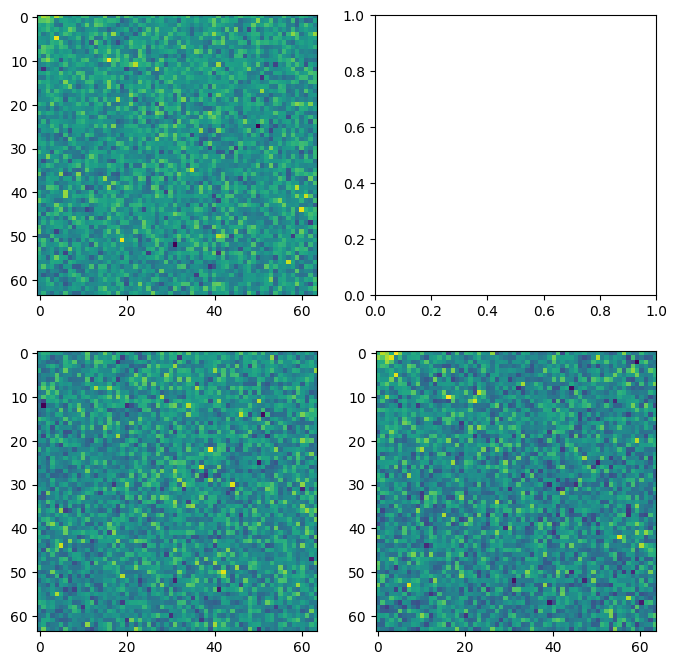

In [15]:
idx = np.random.randint(len(val_dset))
inp_tmp, tar_tmp, *_ = val_dset[idx]
ncols = len(tar_tmp)
nrows = 2
_,ax = plt.subplots(figsize=(4*ncols,4*nrows),ncols=ncols,nrows=nrows)
for i in range(min(ncols,len(inp_tmp))):
    ax[0,i].imshow(inp_tmp[i])

for channel_id in range(ncols):
    ax[1,channel_id].imshow(tar_tmp[channel_id])

In [16]:
if data_t_list is not None:
    val_dset.reduce_data(t_list=data_t_list)

if disable_stochasticity is True:
    print('Disabling stochasticity in the model for coverage computation')
    model.non_stochastic_version = True

In [18]:
import torch.nn as nn 
class NnModel(nn.Module):
    def __init__(self, model):
        super(NnModel, self).__init__()
        self.model = model
    
    def forward(self, x):
        return self.model(x)[0]

    def normalize_target(self, x):
        return self.model.normalize_target(x)

singleoutput_model = NnModel(model).cuda()

### Finding the optimal mixing ratio.

In [ ]:


pred_tiled, rec_loss, logvar_tiled, patch_psnr_tuple, pred_std_tiled= get_dset_predictions(model, val_dset,batch_size,
                                               num_workers=num_workers,
                                               mmse_count=mmse_count,
                                                model_type = config.model.model_type,
                                              )
tmp = np.round([x.item() for x in patch_psnr_tuple],2)
print('Patch wise PSNR, as computed during training', tmp,np.mean(tmp))
pred = stitch_predictions(pred_tiled,val_dset )
if 'target_idx_list' in config.data and config.data.target_idx_list is not None and len(config.data.target_idx_list) > pred[0].shape[-1]:
    # it makes it a list. donot make it unless necessary.
    pred = [pred[i][...,:len(config.data.target_idx_list)] for i in range(len(pred))]


100%|██████████| 53/53 [00:08<00:00,  6.37it/s]


Patch wise PSNR, as computed during training [21.9  23.03] 22.465


In [ ]:
mean_tar = model.data_mean['target'].cpu().numpy()
std_tar = model.data_std['target'].cpu().numpy()
assert mean_tar.shape == (1,2,1,1)
assert mean_tar.shape == std_tar.shape

inp_arr = []
tar_arr = []
for i in tqdm(range(len(val_dset))):
    inp, tar = val_dset[i]
    inp_arr.append(inp[None,:1])
    tar_arr.append((tar - mean_tar)/std_tar)
normalized_inp_patches = np.concatenate(inp_arr,axis=0)
normalized_tar_patches = np.concatenate(tar_arr,axis=0)
del inp_arr, tar_arr
# inp_stitched = stitch_predictions(inp_arr, val_dset)
# inp_stitched = [x[...,0] for x in inp_stitched]
# tar_stitched = stitch_predictions(tar_arr, val_dset)

100%|██████████| 1674/1674 [00:00<00:00, 7446.99it/s]


In [ ]:
pred_tiled.shape, normalized_inp_patches.shape, normalized_tar_patches.shape, pred_tiled.std(), normalized_inp_patches.std(), normalized_tar_patches.std()

((1674, 2, 64, 64),
 (1674, 1, 64, 64),
 (1674, 2, 64, 64),
 np.float32(0.3651289),
 np.float32(0.6827117),
 np.float32(0.9804588))

In [ ]:
from finetunesplit.forward_operator_parameters import get_gaussian_sigma, get_best_mixing
from disentangle.core.psnr import RangeInvariantPsnr
tar =  stitch_predictions(normalized_tar_patches, val_dset)
inp =  stitch_predictions(normalized_inp_patches, val_dset)
inp = [x[...,0] for x in inp]

mixing_t_tar,_ = get_best_mixing(tar, inp,RangeInvariantPsnr, plot=False)
mixing_t_pred,_ = get_best_mixing(pred, inp,RangeInvariantPsnr, plot=False)

# Now we need to find the best mu and sigma
# estimated_inp_patches = normalized_tar_patches[:,0]*mixing_t_tar + normalized_tar_patches[:,1]*(1-mixing_t_tar)
estimated_inp_patches = pred_tiled[:,0]*mixing_t_pred + pred_tiled[:,1]*(1-mixing_t_pred)


100%|██████████| 50/50 [00:00<00:00, 57.08it/s]


Best t value: 0.42


100%|██████████| 50/50 [00:00<00:00, 64.59it/s]

Best t value: 0.44


In [ ]:
from disentangle.core.psnr import RangeInvariantPsnr
psnr_ch1 = np.mean([RangeInvariantPsnr(tar[i][...,0], pred[i][...,0]) for i in range(len(tar))])
psnr_ch2 = np.mean([RangeInvariantPsnr(tar[i][...,1], pred[i][...,1]) for i in range(len(tar))]) 
print(len(tar))
print(f'PSNR\t{psnr_ch1:.2f} {psnr_ch2:.2f}')

2
PSNR	21.45 22.41


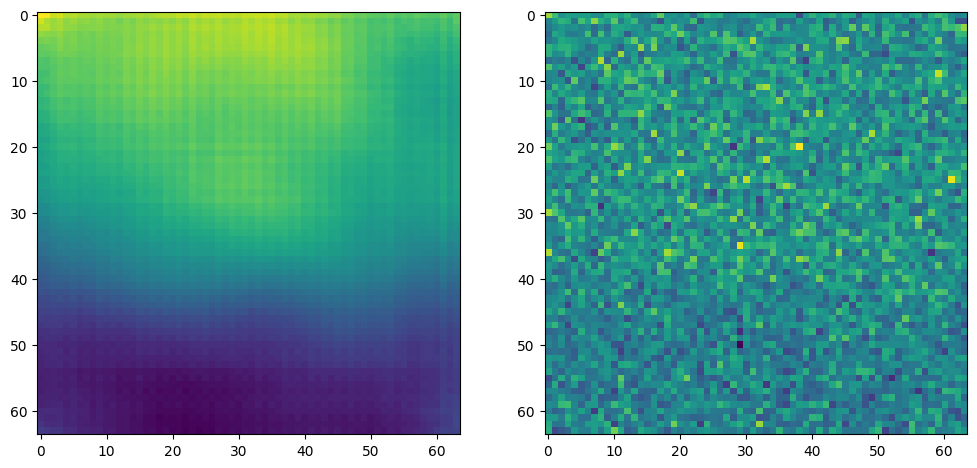

In [ ]:
_,ax = plt.subplots(figsize=(12,6),ncols=2)
idx = np.random.randint(0,estimated_inp_patches.shape[0])
ax[0].imshow(estimated_inp_patches[idx])
ax[1].imshow(normalized_inp_patches[idx,0])

In [ ]:
if with_transforms:
    ch1_transforms = [(TransformEnum.Rotate,{}),(TransformEnum.HFlip, {}),(TransformEnum.VFlip, {})]
    ch2_transforms = [(TransformEnum.Rotate,{}),(TransformEnum.HFlip, {}),(TransformEnum.VFlip, {})]
else:
    ch1_transforms = [(TransformEnum.Identity, {})]
    ch2_transforms = [(TransformEnum.Identity, {})]

inp_transforms = None
if with_inp_transforms:
    inp_transforms = [(TransformEnum.Rotate,{}),(TransformEnum.HFlip, {}),(TransformEnum.VFlip, {})]

if enable_translation_transform:
    ch1_transforms.append((TransformEnum.Translate, {}))
    ch2_transforms.append((TransformEnum.Translate, {}))

if enable_homography_transform:
    dct = {'theta_max':aug_theta_max, 'theta_z_max':aug_theta_z_max, 'shift_max':aug_shift_max, 'device': 'cuda'}
    print('Enabling homography transform', dct)
    ch1_transforms.append((TransformEnum.DeepInV, dct))
    ch2_transforms.append((TransformEnum.DeepInV, dct))

if enable_percentile_evaluation:
    percentiles_to_evaluate = [10, 20,30,40,50,60,70,80,90]
    print('Enabling percentile evaluation for percentiles:', percentiles_to_evaluate)
else:
    percentiles_to_evaluate = None

Enabling percentile evaluation for percentiles: [10, 20, 30, 40, 50, 60, 70, 80, 90]


In [ ]:
# I have an equation x = alpha * y + beta + sigma * N(0,1)
# in pytorch create three learnable parameters, alpha, beta, sigma
from torch import nn
from tqdm import tqdm
from finetunesplit.learn_noise_characteristics import get_noise_parameters
if learn_noise_characteristics:
    noise_params, noise_params_metadata = get_noise_parameters(val_dset, normalized_inp_patches, estimated_inp_patches)
    alpha_dyn = noise_params['alpha_dyn']
    beta_dyn = noise_params['beta_dyn']
    sigma_dyn = noise_params['sigma_dyn']
    alpha_poisson = noise_params['alpha_poisson']
    beta_poisson = noise_params['beta_poisson']
    


loss: 0.288, alpha_dyn: 1.250, beta_dyn: 0.042, sigma_dyn: 0.001, std_loss: 0.018 poisson_loss: 3.408 alpha_poisson: 1.598 beta_poisson: 0.003: 100%|██████████| 6000/6000 [00:39<00:00, 151.63it/s]  

Learned parameters: alpha, beta, sigma 1.2499371767044067 0.04190712794661522 0.0009455429972149432 1.5976977348327637 0.0031773860100656748


In [ ]:
noise_params.keys(), noise_params_metadata.keys()

(dict_keys(['alpha_dyn', 'beta_dyn', 'sigma_dyn', 'alpha_poisson', 'beta_poisson']),
 dict_keys(['alpha_dyn_arr', 'beta_dyn_arr', 'sigma_dyn_arr', 'loss_arr', 'std_loss_arr', 'poisson_loss_arr', 'poisson_alpha_dyn_arr', 'poisson_beta_dyn_arr', 'pois_handler']))

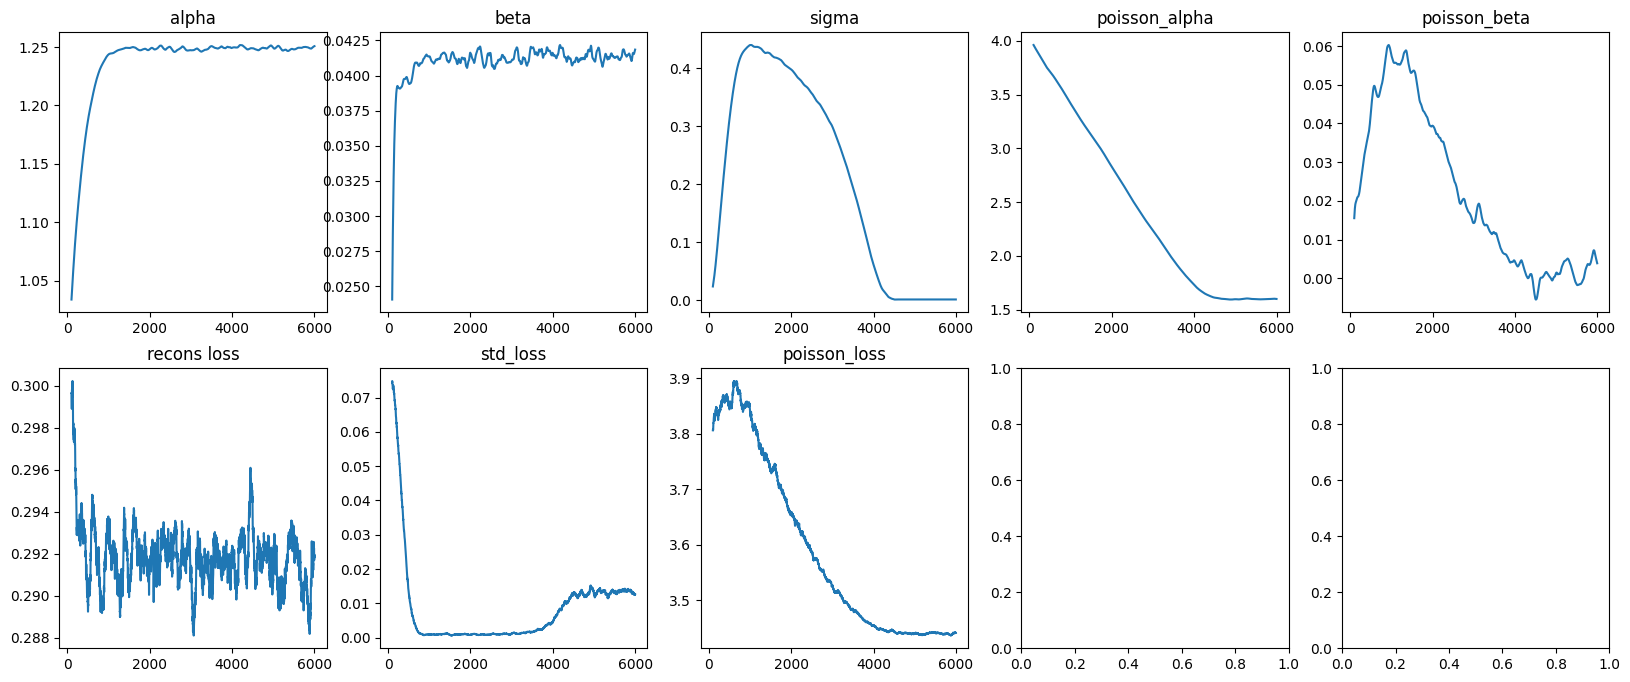

In [ ]:
import pandas as pd 
if learn_noise_characteristics:
    alpha_dyn_arr = noise_params_metadata['alpha_dyn_arr']
    beta_dyn_arr = noise_params_metadata['beta_dyn_arr']
    sigma_dyn_arr = noise_params_metadata['sigma_dyn_arr']
    loss_arr = noise_params_metadata['loss_arr']
    std_loss_arr = noise_params_metadata['std_loss_arr']
    poisson_loss_arr = noise_params_metadata['poisson_loss_arr']
    poisson_alpha_dyn_arr = noise_params_metadata['poisson_alpha_dyn_arr']
    poisson_beta_dyn_arr = noise_params_metadata['poisson_beta_dyn_arr']
    
    _,ax = plt.subplots(figsize=(20,8),ncols=5,nrows=2)
    pd.Series(alpha_dyn_arr).rolling(100).mean().plot(ax=ax[0,0], title='alpha')
    pd.Series(beta_dyn_arr).rolling(100).mean().plot(ax=ax[0,1], title='beta')
    pd.Series(sigma_dyn_arr).rolling(100).mean().plot(ax=ax[0,2], title='sigma')
    pd.Series(poisson_alpha_dyn_arr).rolling(100).mean().plot(ax=ax[0,3], title='poisson_alpha')
    pd.Series(poisson_beta_dyn_arr).rolling(100).mean().plot(ax=ax[0,4], title='poisson_beta')


    pd.Series(loss_arr).rolling(100).mean().plot(ax=ax[1,0], title='recons loss')
    pd.Series(std_loss_arr).rolling(100).mean().plot(ax=ax[1,1], title='std_loss')
    pd.Series(poisson_loss_arr).rolling(100).mean().plot(ax=ax[1,2], title='poisson_loss')


1034
1451
2


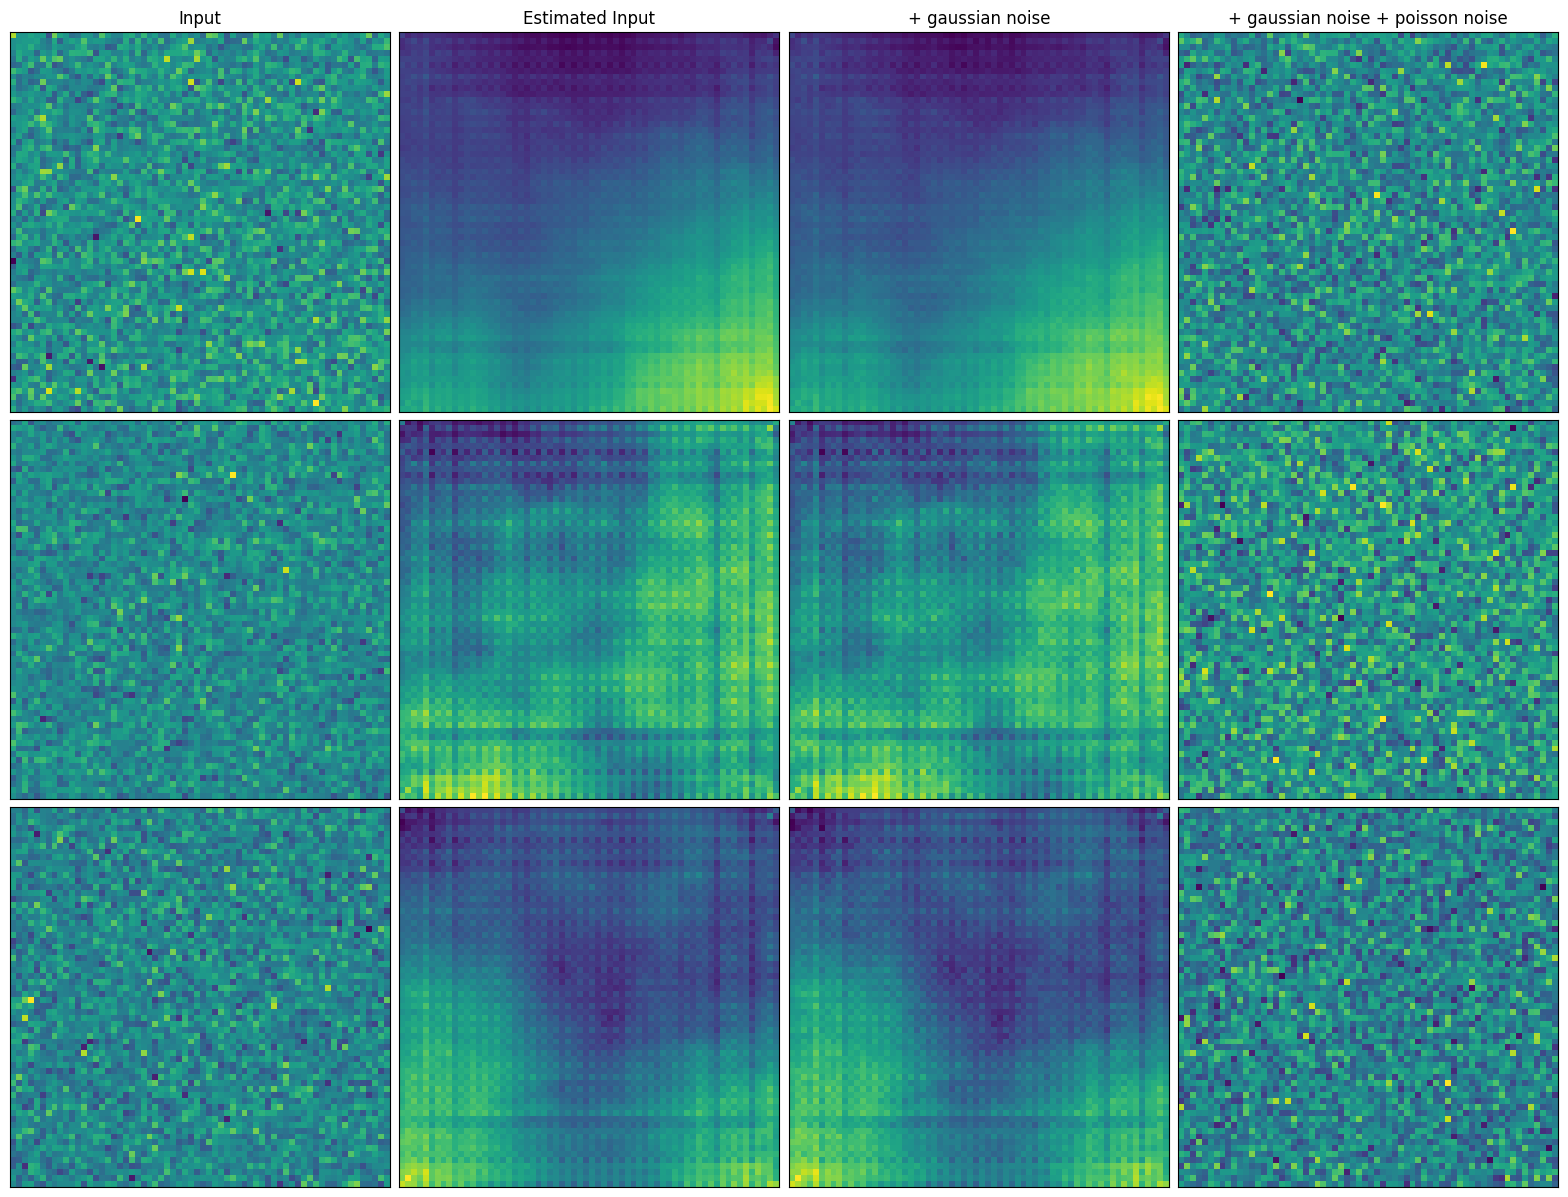

In [ ]:
from disentangle.analysis.plot_utils import clean_ax
if learn_noise_characteristics:
    pois_handler = noise_params_metadata['pois_handler']
    
    _,ax = plt.subplots(figsize=(20,15),ncols=4,nrows=3)
    for row_idx in range(3):
        idx = np.random.randint(0,estimated_inp_patches.shape[0])
        print(idx)
        ax[row_idx,0].imshow(normalized_inp_patches[idx,0])
        ax[row_idx,1].imshow(estimated_inp_patches[idx])
        noise_free = estimated_inp_patches[idx]*alpha_dyn + beta_dyn
        gaussian_noise = sigma_dyn*np.random.randn(*estimated_inp_patches[idx].shape)
        with_poisson_noise = pois_handler.add_poisson_noise(torch.Tensor(noise_free)).detach().cpu().numpy()
        ax[row_idx,2].imshow(gaussian_noise + noise_free)
        ax[row_idx, 3].imshow(gaussian_noise + with_poisson_noise)
        
        if row_idx == 0:
            ax[row_idx,0].set_title('Input')
            ax[row_idx,1].set_title('Estimated Input')
            ax[row_idx,2].set_title('+ gaussian noise')
            ax[row_idx,3].set_title('+ gaussian noise + poisson noise')
        
    clean_ax(ax)
    plt.subplots_adjust(wspace=0.02, hspace=0.02)

In [ ]:
# from disentangle.analysis.forward_operator_parameters import get_gaussian_sigma, get_best_mixing
input_gaussian_noise_std = None#get_gaussian_sigma(normalized_inp_patches)
poisson_scaling = None
poisson_offset = None
if learn_noise_characteristics:
    # # I have an equation x = alpha * y + beta + sigma * N(0,1)
    mu = beta_dyn
    sigma = alpha_dyn
    input_gaussian_noise_std = sigma_dyn
    mixing_t = mixing_t_pred
    poisson_scaling = alpha_poisson
    poisson_offset = beta_poisson
    # add_poisson_noise(torch.Tensor(noise_free), alpha_poisson.item(), beta_poisson.item(), mean_inp, std_inp).numpy()
else:
    mixing_t, mu, sigma = get_forward_operator_parameters(val_dset, pred_tiled, normalized_inp_patches, input_gaussian_noise_std= input_gaussian_noise_std,plot=True)
forward_operator_params = {
    'mixing_t_min': max(0.1,mixing_t - delta_t),
    'mixing_t_max': min(0.9,mixing_t + delta_t),
    'mu': mu,
    'sigma': sigma,
    'gaussian_noise_std': input_gaussian_noise_std,
    'poisson_handler': pois_handler if learn_noise_characteristics else None,}
print(forward_operator_params)

{'mixing_t_min': np.float64(0.33999999999999997), 'mixing_t_max': np.float64(0.54), 'mu': 0.04190712794661522, 'sigma': 1.2499371767044067, 'gaussian_noise_std': 0.0009455429972149432, 'poisson_handler': <finetunesplit.posterior_sampler.PoissonNoiseHander object at 0x7f16a48ee660>}


In [ ]:
nTar = pred[0].shape[-1]
is_list_prediction = isinstance(pred, list)
tar_unnorm = (val_dset._data if not is_list_prediction else [val_dset.dsets[i]._data for i in range(len(val_dset.dsets))])

if "target_idx_list" in config.data and config.data.target_idx_list is not None:
    nTar =len(config.data.target_idx_list)

if 'input_idx' in config.data and config.data.input_idx is not None:
    inp_unnorm = [x[...,config.data.input_idx] for x in tar_unnorm] if is_list_prediction else tar_unnorm[...,config.data.input_idx]
    tar_unnorm = [x[...,:nTar] for x in tar_unnorm] if is_list_prediction else tar_unnorm[...,:nTar]
else:
    inp_unnorm = [x.mean(axis=-1) for x in tar_unnorm]


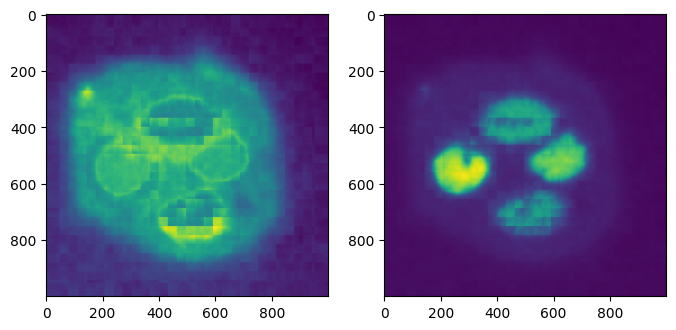

In [ ]:
_,ax = plt.subplots(figsize=(8,4),ncols=2)
if is_list_prediction:
    ax[0].imshow(pred[0][0,...,0])
    ax[1].imshow(pred[0][0,...,1])
else:
    ax[0].imshow(pred[0,...,0])
    ax[1].imshow(pred[0,...,1])

### A model to yield augmented predictions.

In [ ]:
import torch.nn as nn 
# class NnModel(nn.Module):
#     def __init__(self, model):
#         super(NnModel, self).__init__()
#         self.model = model
    
#     def forward(self, x):
#         return self.model(x)[0]

singleoutput_model = NnModel(model).cuda()

In [ ]:
pred_transform_obj = get_transform_obj(ch1_transforms, ch2_transforms, correlation_preserving_transforms=corr_pres_trans)
print('')
print('')
inp_transform_obj = get_input_transform_obj(inp_transforms) if with_inp_transforms else None


Transforms for Ch1: [('identity', {})]
Transforms for Ch2: [('identity', {})]
Using correlation preserving transforms
Using transform types: {0: [Identity(transform_type='identity')], 1: [Identity(transform_type='identity')]}


Transforms for Ch1: [('rotate', {}), ('hflip', {}), ('vflip', {})]
Transforms for Ch2: [('rotate', {}), ('hflip', {}), ('vflip', {})]
Using correlation preserving transforms
Using transform types: {0: [Rotate(transform_type='rotate'), HFlip(transform_type='hflip'), VFlip(transform_type='vflip')], 1: [Rotate(transform_type='rotate'), HFlip(transform_type='hflip'), VFlip(transform_type='vflip')]}


In [ ]:
aug_model = PosteriorSampler(singleoutput_model, pred_transform_obj, forward_operator_params=forward_operator_params, mmse_count=mmse_count,
                                        k_forward_pass=k_forward_pass, input_transforms=inp_transform_obj, keep_original_input_fraction=keep_original_input_fraction)

[PosteriorSampler] k_forward_pass: 2
[PosteriorSampler] mixing_t range: [0.33999999999999997, 0.54], mu: 0.04190712794661522, sigma: 1.2499371767044067, gaussian_noise_std: 0.0009455429972149432
[PosteriorSampler] Input transforms enabled


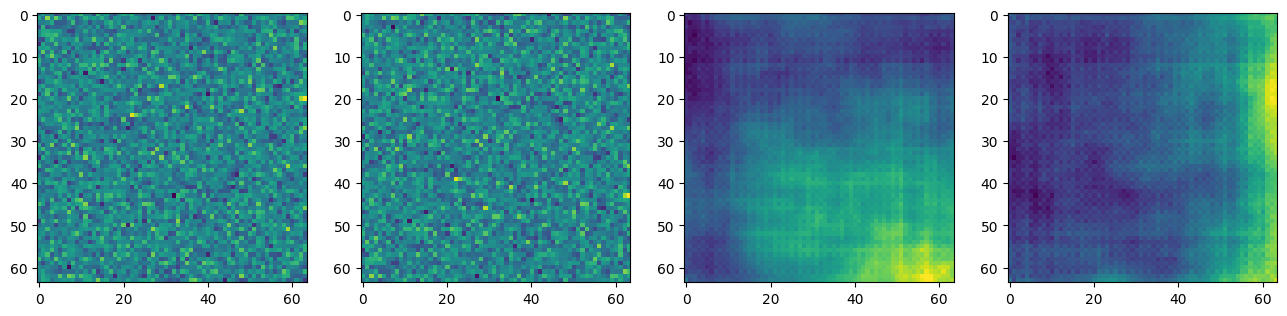

In [ ]:
if inp_transform_obj is not None:
    dloader = DataLoader(val_dset, batch_size=5, shuffle=False, num_workers=0)
    for batch in dloader:
        inp_b, tar_b = batch
        break
    
    with torch.no_grad():   
        pred, applied_transforms, inp_transformed = aug_model.one_forward_pass_inp(inp_b.cuda())

    _,ax = plt.subplots(figsize=(16,4),ncols=4)
    ax[0].imshow(inp_b[0,0])
    ax[1].imshow(inp_transformed[0,0].cpu())
    ax[2].imshow(pred[0,0].cpu())
    ax[3].imshow(pred[1,0].cpu())

In [ ]:
image_size_for_grid_centers

32

In [ ]:
if custom_image_size is None:
    skip_pixels = config.data.image_size - image_size_for_grid_centers
else:
    skip_pixels = custom_image_size - image_size_for_grid_centers

In [ ]:

pred_b_list = []
var_list = []
err_list  = []
one_step_pred_mmse_list = []
dloader = DataLoader(val_dset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
for batch in tqdm(dloader):
    with torch.no_grad():
        inp_b, tar_b = batch
        tar_b_normalized = model.normalize_target(tar_b.cuda()).cpu().numpy()
        pred_b, one_step_pred_mmse = aug_model(inp_b.cuda())
        
        pred_b = [x.cpu().numpy()[:,None] for x in pred_b]
        pred_b = np.concatenate(pred_b, axis=1)
        one_step_pred_mmse = one_step_pred_mmse.cpu().numpy()
        
        
        ec_pred_b = pred_b
        ec_tar_b_normalized = tar_b_normalized
        ec_one_step_pred_mmse = one_step_pred_mmse
        if skip_pixels > 1:
            ec_pred_b = pred_b[...,skip_pixels//2:-skip_pixels//2,skip_pixels//2:-skip_pixels//2]
            ec_tar_b_normalized = tar_b_normalized[...,skip_pixels//2:-skip_pixels//2,skip_pixels//2:-skip_pixels//2]
            ec_one_step_pred_mmse = one_step_pred_mmse[...,skip_pixels//2:-skip_pixels//2,skip_pixels//2:-skip_pixels//2]
        
        var_b, err_b = compute_for_one_batch(ec_pred_b, ec_tar_b_normalized, elem_size=elem_size,mmse_sample_for_error=ec_one_step_pred_mmse if compute_error_from_first_prediction else None,)
        one_step_pred_mmse_list.append(one_step_pred_mmse)
        # compute for one batch, both calibration and coverage. 
        pred_b_list.append(pred_b[:,0])
        var_list.append(var_b)
        err_list.append(err_b)

pred_b = np.concatenate(pred_b_list, axis=0)
var = np.concatenate(var_list, axis=0)
err = np.concatenate(err_list, axis=0)
one_step_pred_mmse = np.concatenate(one_step_pred_mmse_list, axis=0)

100%|██████████| 53/53 [00:13<00:00,  3.84it/s]


In [ ]:
pred_stitched  = stitch_predictions(pred_b, val_dset)
pred_one_step_stitched = stitch_predictions(one_step_pred_mmse, val_dset)

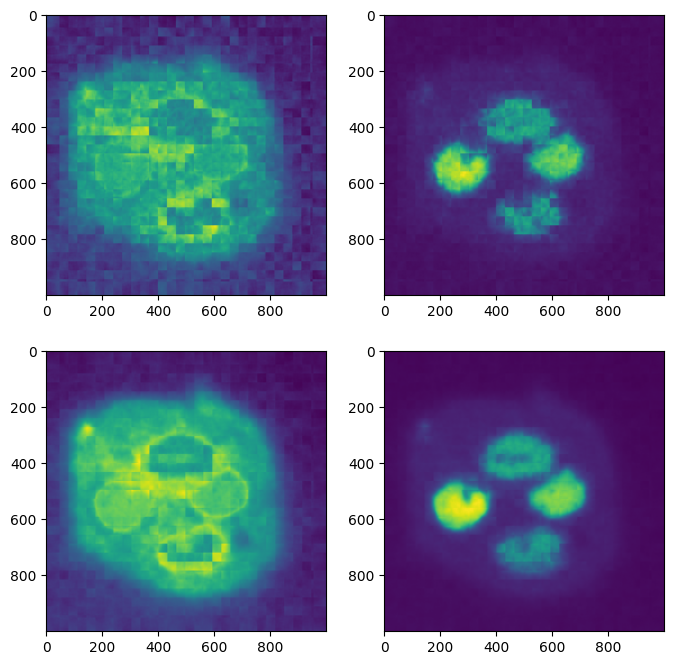

In [ ]:
_,ax = plt.subplots(figsize=(8,8),ncols=2,nrows=2)
if is_list_prediction:
    ax[0,0].imshow(pred_stitched[0][0,...,0])
    ax[0,1].imshow(pred_stitched[0][0,...,1])
    ax[1,0].imshow(pred_one_step_stitched[0][0,...,0])
    ax[1,1].imshow(pred_one_step_stitched[0][0,...,1])
else:
    ax[0,0].imshow(pred_stitched[0,...,0])
    ax[0,1].imshow(pred_stitched[0,...,1])
    ax[1,0].imshow(pred_one_step_stitched[0,...,0])
    ax[1,1].imshow(pred_one_step_stitched[0,...,1])

In [ ]:
tar_unnorm[0].shape

(1, 1000, 1000, 2)

In [ ]:
is_list_prediction

True

In [ ]:
if is_list_prediction:
    print(RangeInvariantPsnr(tar_unnorm[0][0,...,0]*1.0, pred_stitched[0][0,...,0]).item(), RangeInvariantPsnr(tar_unnorm[0][0,...,1]*1.0, pred_stitched[0][0,...,1]).item())
else:
    print(RangeInvariantPsnr(tar_unnorm[0,...,0]*1.0, pred_stitched[0,...,0]).item(), RangeInvariantPsnr(tar_unnorm[0,...,1]*1.0, pred_stitched[0,...,1]).item())

20.882511138916016 22.971691131591797


In [ ]:
from finetunesplit.calibration.find_optimal_parameters import find_optimal_params
output, metadata = find_optimal_params(err, var, percentiles_to_evaluate=percentiles_to_evaluate, q_bkg=0.01, around_center=False)
factors_shifted, offsets_shifted = output
print('Optimal factors:', factors_shifted)
print('Optimal offsets:', offsets_shifted)

q_var = metadata['q_var']
q_err = metadata['q_err']

Offset based on background quantile 0.43531203
Offset based on background quantile 0.35752892
Starting the grid search
0.38 10 D0
1.32 20 D0
2.86 30 D0
4.67 40 D0
Upscaling 10 -> 20
6.96 50 D0
11.79 70 D0
16.89 90 D0
21.65 110 D0
Upscaling 20 -> 40
26.05 130 D0
33.91 170 D0
40.71 210 D0
45.80 250 D0
Upscaling 40 -> 80
50.40 290 D1
40.71 210 D2
45.80 250.0 D2
48.26 270.0 D2
50.40 290.0 D3
48.26 270.0 D4
49.27 280.0 D4
49.81 285.0 D4
50.40 290.0 D5
49.81 285.0 D6
50.14 287.5 D7
Using 40.71 percentile for 50, Factor:250 Error:5.866436384571097

Starting the grid search
0.73 10 D0
2.20 20 D0
3.75 30 D0
5.10 40 D0
Upscaling 10 -> 20
6.39 50 D0
8.54 70 D0
10.34 90 D0
11.87 110 D0
Upscaling 20 -> 40
13.29 130 D0
15.79 170 D0
18.00 210 D0
19.97 250 D0
Upscaling 40 -> 80
21.88 290 D0
25.34 370 D0
28.01 450 D0
30.60 530 D0
Upscaling 80 -> 160
32.99 610 D0
37.49 770 D0
41.58 930 D0
45.39 1090 D0
Upscaling 160 -> 320
48.60 1250 D0
54.16 1570 D1
48.60 1250 D2
51.48 1410.0 D3
50.11 1330.0 D3
49.34 1

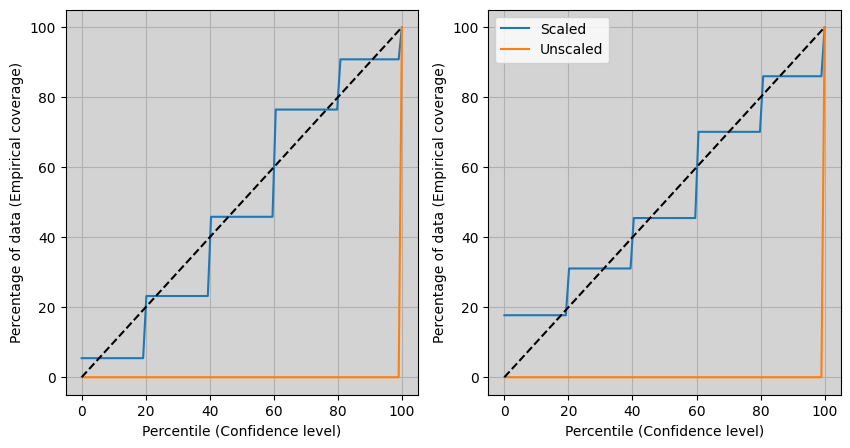

In [ ]:
data_left_oriented = plot_coverage_plot( var -np.array(q_var)[None,:,None], 
                                         err, factors_shifted, [k+q_err[i] for i,k in enumerate(offsets_shifted)], around_center=False)

In [ ]:
perfect = np.linspace(0,100,100)
for col_idx in range(var.shape[1]):
    act = data_left_oriented[col_idx]['scaled'][1]
    mean_err = np.abs(perfect - act).mean() 
    max_err = np.abs(perfect - act).max()
    print(f'LeftOriented: Channel {col_idx} MAE {mean_err:.2f}, MAX Err {max_err:.2f}')

LeftOriented: Channel 0 MAE 6.12, MAX Err 16.19
LeftOriented: Channel 1 MAE 5.97, MAX Err 17.71


In [ ]:
outs = []
inp, _ = val_dset[0]
inp = torch.Tensor(inp[None]).cuda()
for _ in range(5):
    out,_ = model(inp)
    outs.append(out.detach().cpu().numpy())

In [ ]:
np.abs(outs[0] - outs[1]).max()

np.float32(0.1237251)